In [1]:
import torch
import einops

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import itertools

from utils.components import *
from utils.config import *
from utils.einmask import EinMask
from utils.dataset import NinoData

from utils.masking import *

from omegaconf import OmegaConf
from dataclasses import replace

import torch_harmonics

In [2]:
mpl.rcParams['figure.dpi'] = 300            # High resolution
mpl.rcParams['font.size'] = 9               # or 10, depending on guidelines
mpl.rcParams['axes.linewidth'] = 0.5        # Axis line thickness
mpl.rcParams['lines.linewidth'] = 1.0       # Default plot line thickness
mpl.rcParams['legend.fontsize'] = 7         # Legend font size

In [3]:
eval_data = xr.open_zarr("runs/2321585/piControl_eval.zarr")

In [4]:
eval_data

<xarray.Dataset> Size: 8GB
Dimensions:           (ens: 8, lag: 24, lat: 41, lon: 91, time: 1168)
Coordinates:
  * ens               (ens) int64 64B 0 1 2 3 4 5 6 7
  * lag               (lag) int64 192B 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24
  * lat               (lat) float64 328B -20.0 -19.0 -18.0 ... 18.0 19.0 20.0
  * lon               (lon) float64 728B 90.0 92.0 94.0 ... 266.0 268.0 270.0
    month             (time) int64 9kB ...
  * time              (time) object 9kB 1900-01-01 00:00:00 ... 1997-04-01 00...
    variable          <U12 48B ...
Data variables:
    temp_ocn_0a_pred  (time, lag, lat, lon, ens) float64 7GB ...
    temp_ocn_0a_tgt   (time, lag, lat, lon) float64 837MB ...

In [5]:
def crps_gaussian(x: np.ndarray, mu: np.ndarray, std: np.ndarray) -> np.ndarray:
    from scipy.special import erf
    """CRPS for Gaussian distribution.

    Args:
        x (np.ndarray): Ground truth data of size (n_samples, n_features)
        mu (np.ndarray): Mean of size (n_samples, n_features)
        std (np.ndarray): Standard deviation of size (n_samples, n_features)

    Returns:
        crps (np.ndarray): CRPS of size (n_samples, n_features) 
    """
    sqrtPi = np.sqrt(np.pi)
    z = (x - mu) / std 
    phi = np.exp(-z ** 2 / 2) / (np.sqrt(2) * sqrtPi) #standard normal pdf
    crps = std * (z * erf(z / np.sqrt(2)) + 2 * phi - 1 / sqrtPi) #crps as per Gneiting et al 2005
    return crps 

def compute_rank_histogram(obs, ens):
    """
    Compute the rank histogram for a set of observations and ensemble forecasts.
    
    Parameters
    ----------
    obs : ndarray of shape (M,)
        The observations, flattened along all spatial/temporal dimensions.
    ens : ndarray of shape (M, N)
        The ensemble forecasts, where M is the total number of samples
        and N is the number of ensemble members.

    Returns
    -------
    ranks : ndarray of shape (N+1,)
        The rank histogram counts for ranks from 0 to N.
    """
    M, N = ens.shape
    # Initialize counts for each possible rank: 0..N
    rank_counts = np.zeros(N + 1, dtype=np.int64)

    # For each sample, compute how many ensemble members are less than obs
    # This integer is the rank of obs in the sorted ensemble.
    # rank = 0 means obs is smaller than all ensemble members,
    # rank = N means obs is larger than all ensemble members.
    for i in range(M):
        rank = np.sum(ens[i, :] < obs[i])
        rank_counts[rank] += 1

    return rank_counts / M

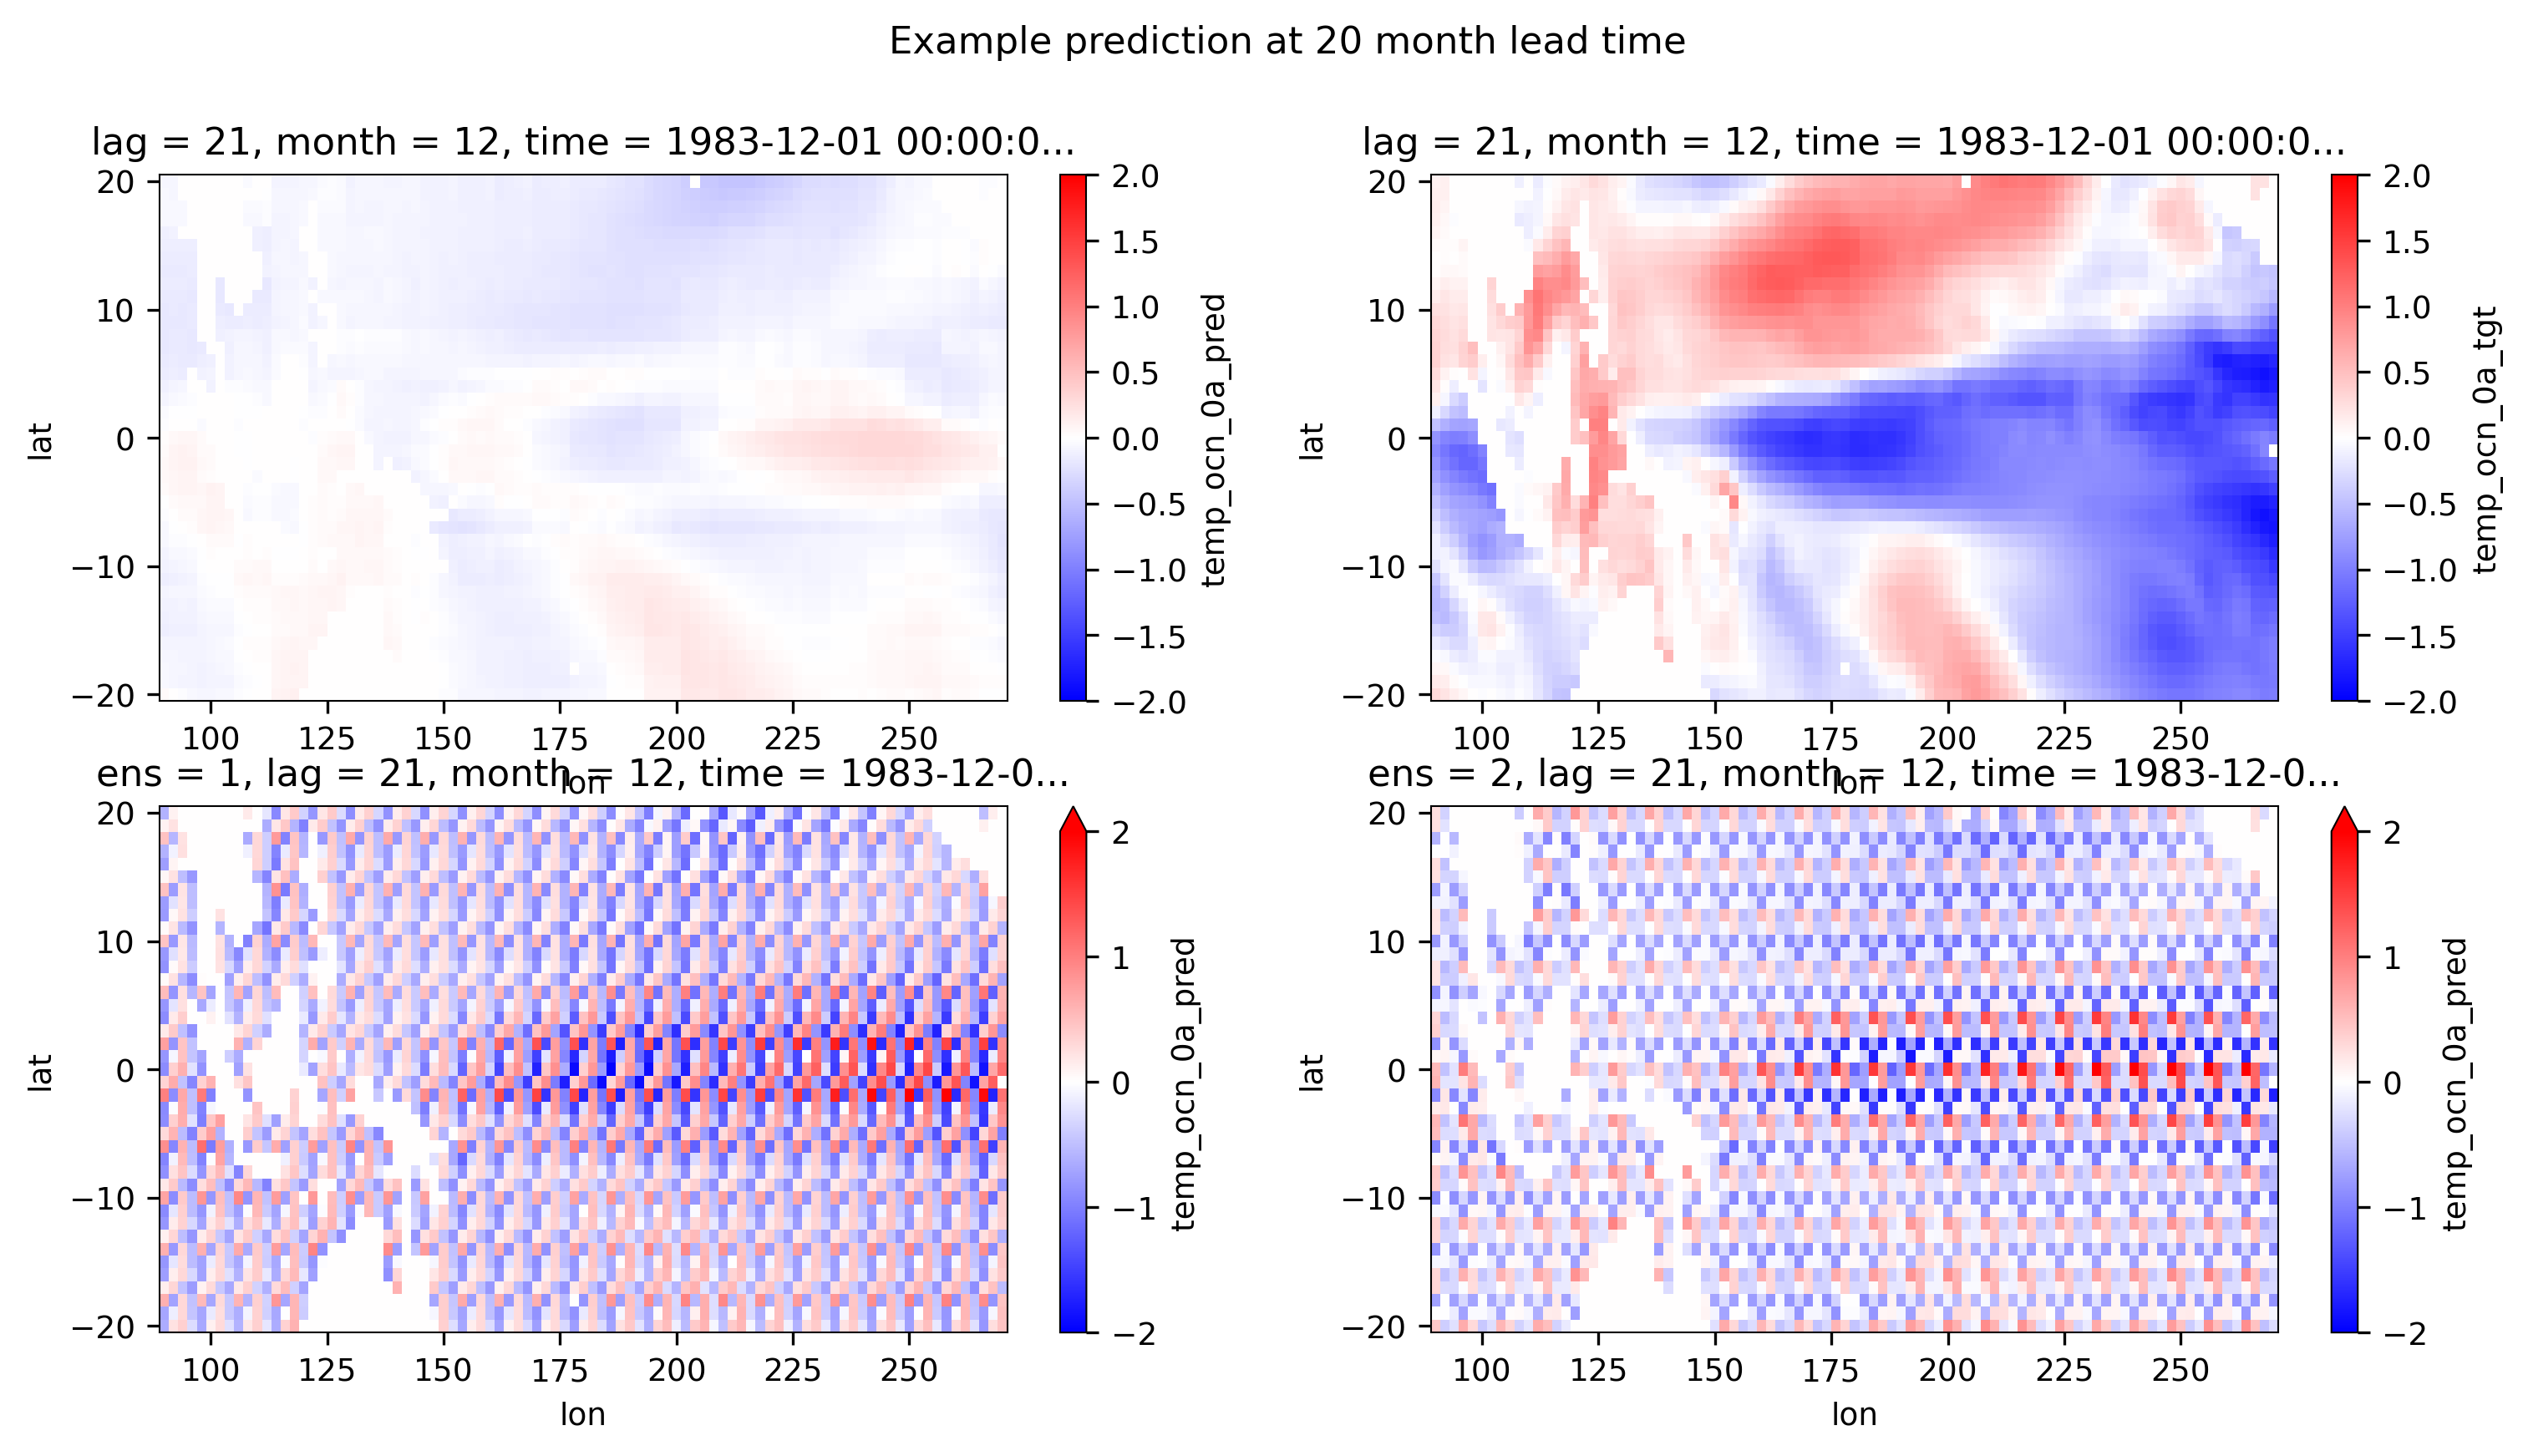

In [6]:
plt.figure(figsize=(12,6))
tau = 21
plt.subplot(221)
eval_data['temp_ocn_0a_pred'].sel(time="1983-12-01", lag=tau).mean("ens").plot(vmin=-2, vmax = 2, cmap= 'bwr')
plt.subplot(222)
eval_data['temp_ocn_0a_tgt'].sel(time="1983-12-01", lag=tau).plot(vmin=-2, vmax = 2, cmap= 'bwr')
plt.suptitle("Example prediction at 20 month lead time")
plt.subplot(223)
eval_data['temp_ocn_0a_pred'].sel(time="1983-12-01", lag=tau, ens=1).plot(vmin=-2, vmax = 2, cmap= 'bwr')
plt.subplot(224)
eval_data['temp_ocn_0a_pred'].sel(time="1983-12-01", lag=tau, ens=2).plot(vmin=-2, vmax = 2, cmap= 'bwr')
plt.savefig('samples.png')

In [7]:
import math

def get_field_metrics(eval_data: xr.Dataset):
    for var in ["temp_ocn_0a"]:
        tgt, pred = eval_data[f"{var}_tgt"], eval_data[f'{var}_pred']
        pcc = xr_pcc(pred.mean('ens'), tgt, ('lat', 'lon')).mean(('time'))
        rmse = xr_rmse(pred.mean('ens'), tgt, ('lat', 'lon')).mean(('time'))
        ssr = xr_spread_skill(pred, tgt, ('lat', 'lon')).mean(('time'))
        
    return {
        "pcc": pcc, "rmse": rmse, "ssr": ssr
    }

def get_nino_metrics( eval_data: xr.Dataset):
    nino34_tgt, nino34_pred = get_nino34(eval_data["temp_ocn_0a_tgt"]), get_nino34(eval_data["temp_ocn_0a_pred"]).mean("ens")
    nino4_tgt, nino4_pred = get_nino4(eval_data["temp_ocn_0a_tgt"]), get_nino4(eval_data["temp_ocn_0a_pred"]).mean("ens")
    
    nino34_pcc = xr_pcc(nino34_pred, nino34_tgt, ("time",))
    nino4_pcc = xr_pcc(nino4_pred, nino4_tgt, ("time",))

    nino34_rmse = xr_rmse(nino34_pred, nino34_tgt, ("time",))
    nino4_rmse = xr_rmse(nino4_pred, nino4_tgt, ("time",))

    nino4_thresh_month =  1 + np.argwhere(nino4_pcc.values > 0.5).max(initial=0)
    nino34_thresh_month = 1 + np.argwhere(nino34_pcc.values > 0.5).max(initial=0)

    nino4_ssr = xr_spread_skill(get_nino4(eval_data["temp_ocn_0a_pred"]), nino4_tgt, ("time",))
    nino34_ssr = xr_spread_skill(get_nino34(eval_data["temp_ocn_0a_pred"]), nino34_tgt, ("time",))

    return {
        "nino34_pcc": nino34_pcc, "nino4_pcc": nino4_pcc,
        "nino34_rmse": nino34_rmse, "nino4_rmse": nino4_rmse,
        "nino34_thresh_month": nino34_thresh_month,
        "nino4_thresh_month": nino4_thresh_month,
        "nino34_ssr": nino34_ssr, "nino4_ssr": nino4_ssr
    }
    

@staticmethod
def get_nino4(da: xr.DataArray):
    return da.sel(lon=slice(160, 210), lat=slice(-5, 5)).mean(dim=['lon', 'lat']).rolling(time = 3).mean()

@staticmethod
def get_nino34(da: xr.DataArray):
    return da.sel(lon=slice(190, 240), lat=slice(-5, 5)).mean(dim=['lon', 'lat']).rolling(time = 3).mean()

@staticmethod
def xr_pcc(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
    num = (pred * obs).sum(dim)
    denom = np.sqrt((pred**2).sum(dim)) * np.sqrt((obs**2).sum(dim))
    return num / denom

@staticmethod
def xr_rmse(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
    return np.sqrt(((pred - obs) ** 2).mean(dim))

@staticmethod
def xr_spread_skill(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
    K = pred.sizes["ens"]
    correction = math.sqrt((K + 1) / K)
    mean = pred.mean("ens")
    spread = np.sqrt(pred.var("ens").mean(dim))
    skill = np.sqrt(((obs - mean) ** 2).mean(dim))
    return correction * (spread / skill)


In [8]:
field_metrics = get_field_metrics(eval_data)
nino_metrics = get_nino_metrics(eval_data)

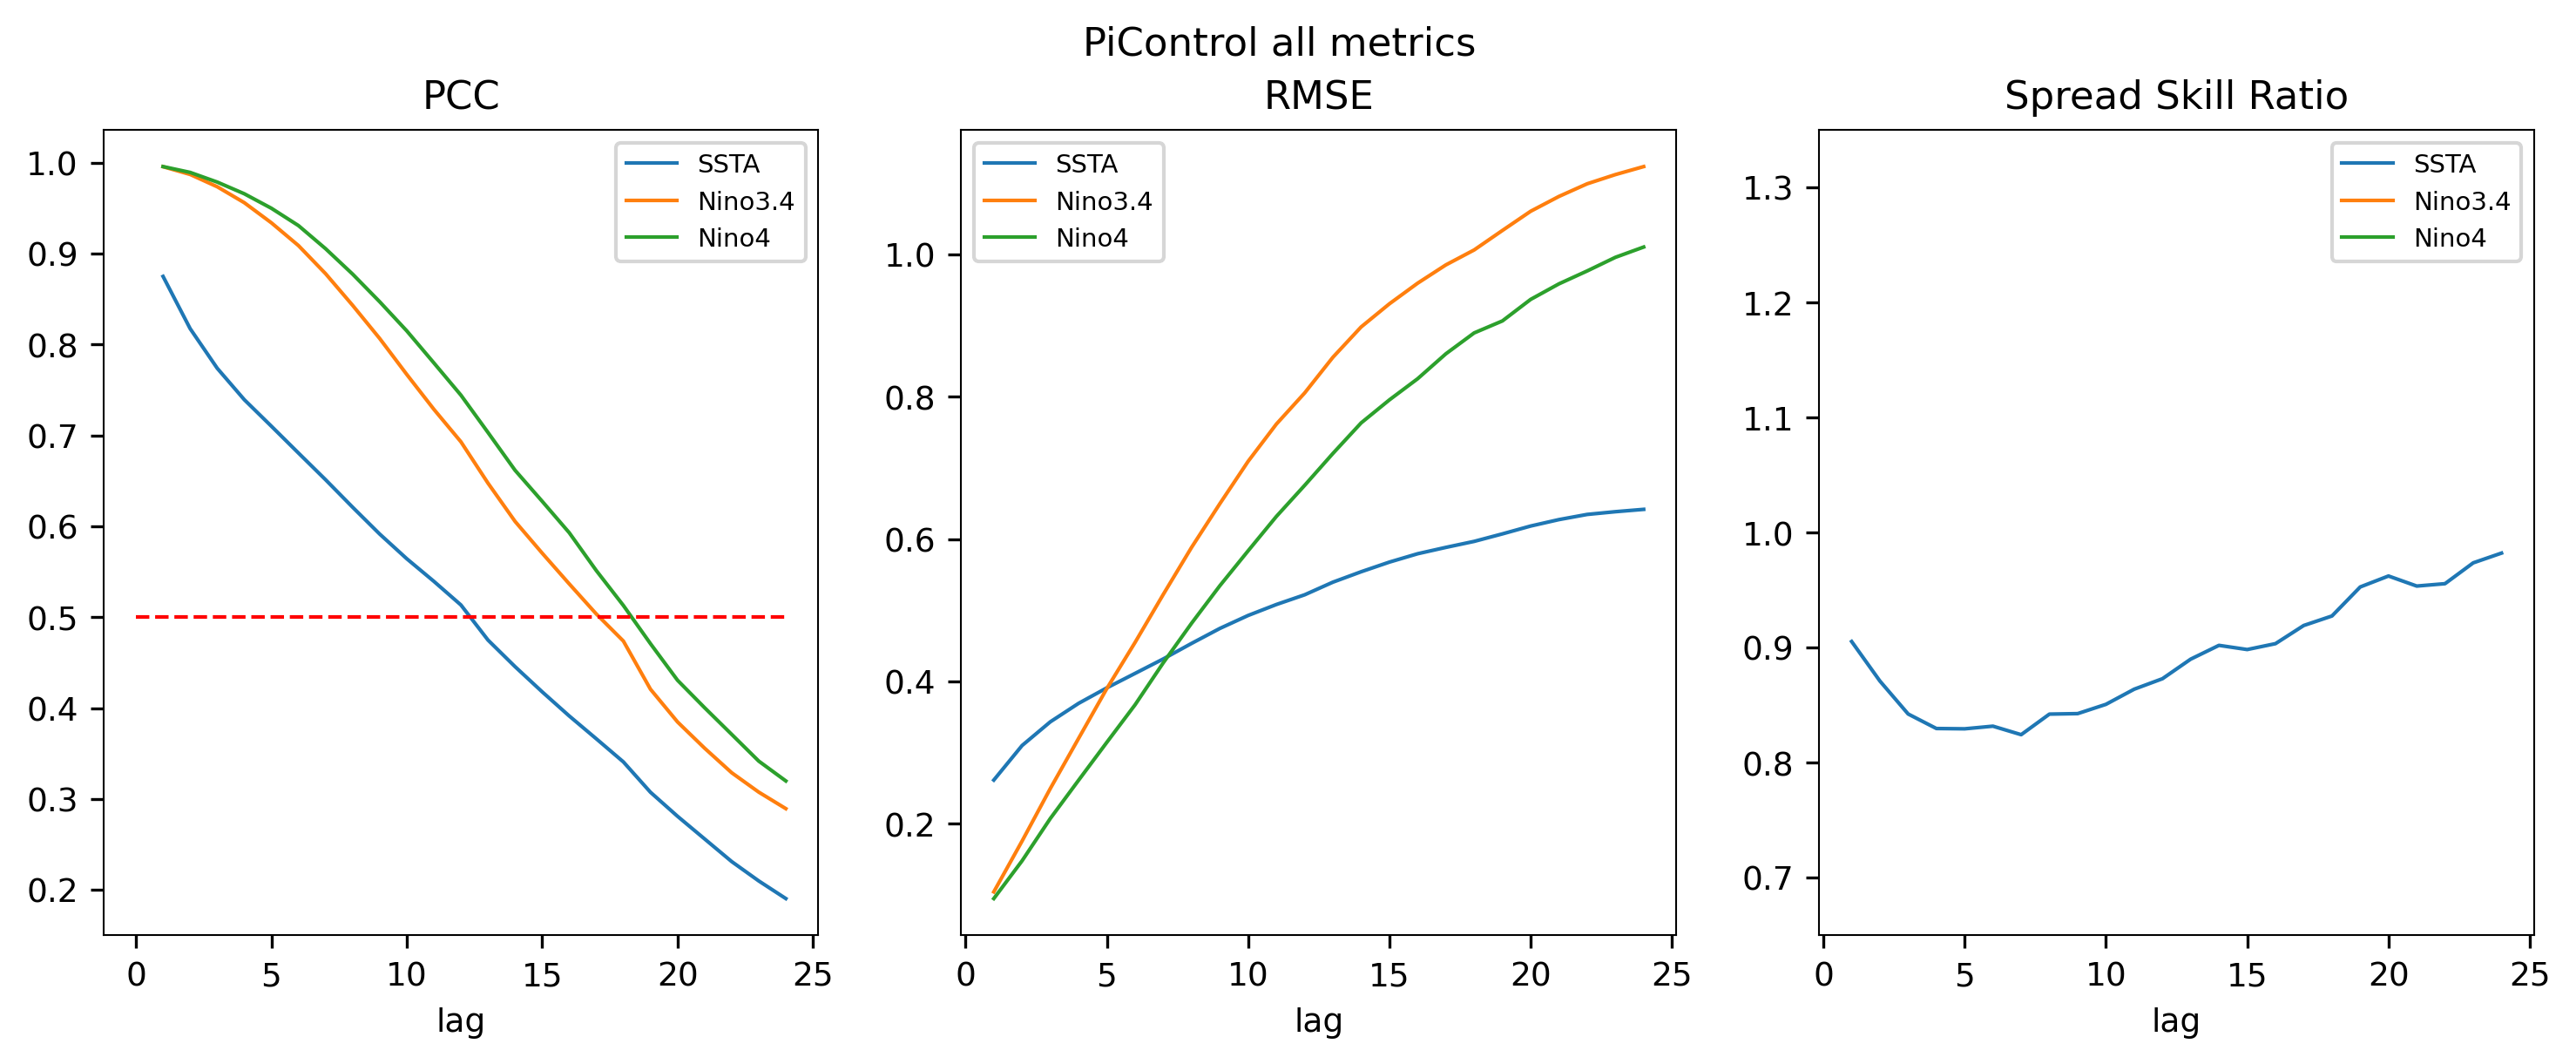

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(131)
field_metrics["pcc"].plot()
nino_metrics["nino34_pcc"].plot()
nino_metrics["nino4_pcc"].plot()
plt.legend(["SSTA", "Nino3.4", "Nino4"])
plt.hlines(0.5, xmin=0, xmax=24, colors='r', linestyles='dashed')
plt.title("PCC")
plt.subplot(132)
field_metrics["rmse"].plot()
nino_metrics["nino34_rmse"].plot()
nino_metrics["nino4_rmse"].plot()
plt.legend(["SSTA", "Nino3.4", "Nino4"])
plt.title("RMSE")
plt.subplot(133)
field_metrics["ssr"].plot()
nino_metrics["nino34_ssr"].plot()
nino_metrics["nino4_ssr"].plot()
plt.legend(["SSTA", "Nino3.4", "Nino4"])
plt.ylim(0.65, 1.35)
plt.title("Spread Skill Ratio")
plt.suptitle('PiControl all metrics')
plt.savefig('metrics.png')

In [10]:
geoformer_acc_nino4 = [0.994,0.963,0.931,0.9,0.87,0.843,0.816,0.789,0.768,0.748,0.732,0.718,0.703,0.677,0.652,0.624,0.592,0.557,0.512,0.455]
geoformer_rmse_nino4 = [0.104,0.167,0.23,0.295,0.339,0.38,0.41,0.427,0.445,0.459,0.467,0.481,0.504,0.527,0.537,0.553,0.592,0.622,0.637,0.672]

nino4_acc_values_old = [
    0.97918123, 0.9797946, 0.97350585, 0.9630004, 0.9482865, 0.93100137,
    0.90889394, 0.88256884, 0.85208493, 0.8207785, 0.78600186, 0.7495376,
    0.712273, 0.67880523, 0.64771086, 0.6198993, 0.58979565, 0.55733985,
    0.49893567, 0.46987474, 0.4426261, 0.4137368, 0.38565788, 0.35940564
]

nino4_rmse_values_old = [
    0.20122607, 0.19745673, 0.22672589, 0.2686358, 0.31706777, 0.36480904,
    0.41812035, 0.4719005, 0.52526784, 0.5734762, 0.6208628, 0.6637392,
    0.7021196, 0.7344313, 0.7619488, 0.7846967, 0.8073986, 0.8298172,
    0.8659962, 0.8820192, 0.8962772, 0.9108972, 0.9243836, 0.93663627
]

Text(0.5, 0.98, 'Nino4 Metric Comparison on PiControl')

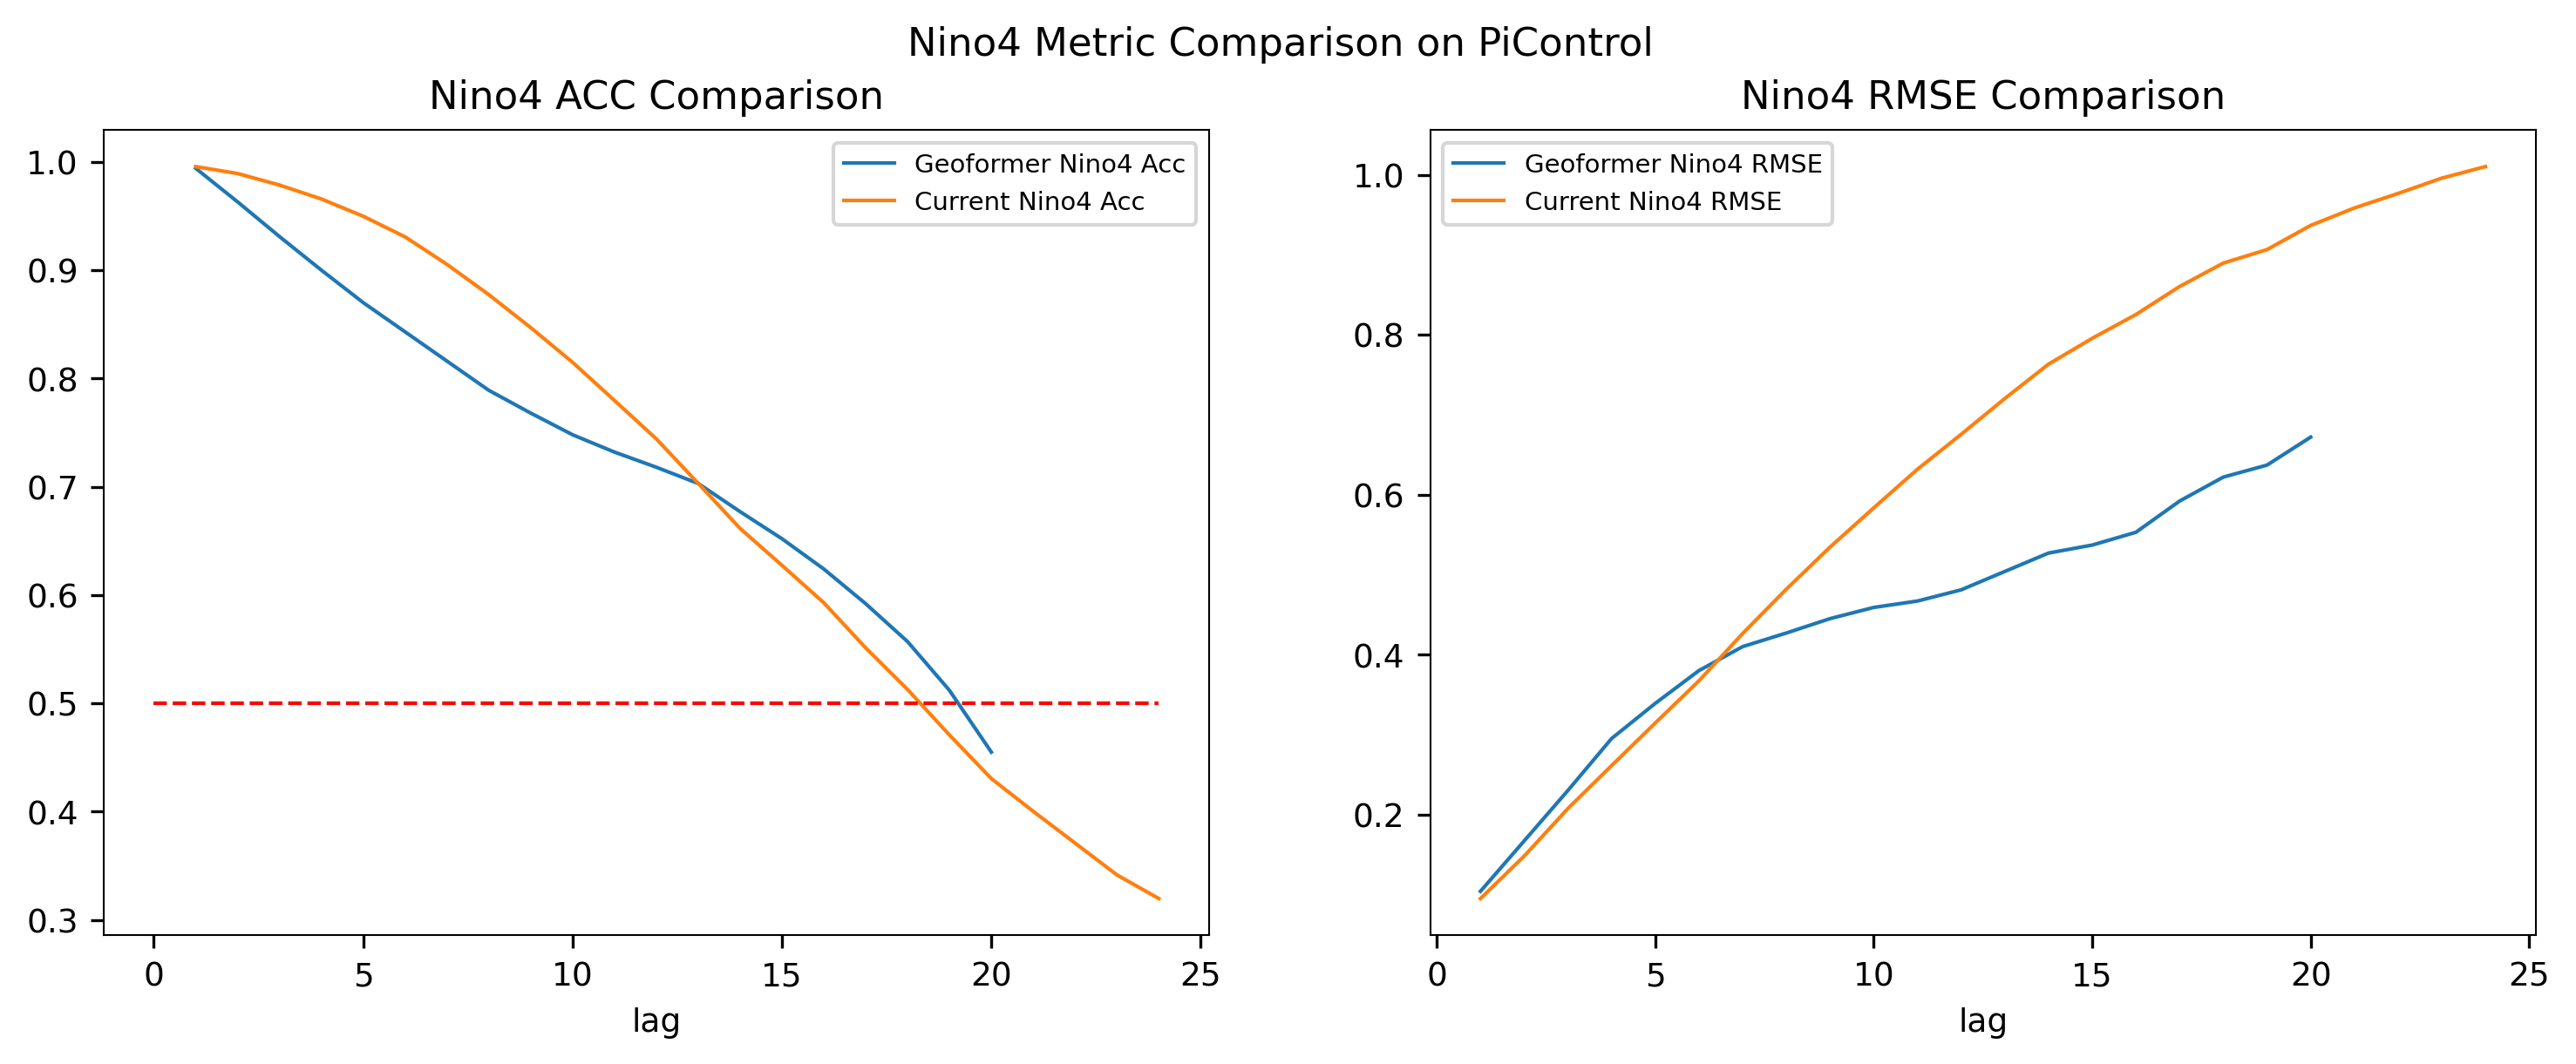

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(np.arange(1, len(geoformer_acc_nino4) + 1), geoformer_acc_nino4, label='Geoformer Nino4 Acc')
nino_metrics["nino4_pcc"].plot(label='Current Nino4 Acc')
plt.hlines(0.5, xmin=0, xmax=24, colors='r', linestyles='dashed')
plt.legend()
plt.title("Nino4 ACC Comparison")
plt.subplot(122)
plt.plot(np.arange(1, len(geoformer_acc_nino4) + 1),geoformer_rmse_nino4, label='Geoformer Nino4 RMSE')
nino_metrics["nino4_rmse"].plot(label='Current Nino4 RMSE')
plt.legend()
plt.title("Nino4 RMSE Comparison")
plt.suptitle("Nino4 Metric Comparison on PiControl")


In [12]:
lsm = eval_data.temp_ocn_0a_tgt.isel(time = 0, lag = 0) != 0
lsm = lsm.rename("lsm")
del lsm["time"]
del lsm["lag"]
del lsm["month"]
eval_data = xr.merge([eval_data, lsm]).compute()

num_predictors = len(eval_data.ens)

filtered_tgt = eval_data.temp_ocn_0a_tgt.where(eval_data.lsm)
filtered_pred = eval_data.temp_ocn_0a_pred.where(eval_data.lsm)

filtered_mean = filtered_pred.mean("ens") 
filtered_std = filtered_pred.std("ens") 
filtered_var = filtered_pred.var("ens") 

filtered_tgt_nino4 = filtered_tgt.sel(lat = slice(-5, 5), lon = slice(190, 240)).mean(dim = ["lat", "lon"]).rolling(time = 3).mean()
filtered_pred_nino4 = filtered_pred.sel(lat = slice(-5, 5), lon = slice(190, 240)).mean(dim = ["lat", "lon"]).rolling(time = 3).mean()
filtered_mean_nino4 = filtered_pred_nino4.mean("ens") 
filtered_std_nino4 = filtered_pred_nino4.std("ens") 
filtered_var_nino4 = filtered_pred_nino4.var("ens") 



In [13]:
monthly_accs, monthly_rmse, monthly_crps, monthly_ssr = [], [], [], []
monthly_nino_accs, monthly_nino_rmse, monthly_nino_crps, monthly_nino_ssr = [], [], [], []

clim_rmse, clim_crps = [], []
clim_nino_rmse, clim_nino_crps = [], []

for month in range(1, 13):
    # 1. Select the data for the month and stack the spatial dimensions
    tgt = filtered_tgt.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    mean = filtered_mean.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    std = filtered_std.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    var = filtered_var.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    # 1.1 For nino4 we don't need to stack space
    tgt_nino4 = filtered_tgt_nino4.sel(time = filtered_mean["time.month"] == month)
    mean_nino4 = filtered_mean_nino4.sel(time = filtered_mean["time.month"] == month)
    std_nino4 = filtered_std_nino4.sel(time = filtered_mean["time.month"] == month)
    var_nino4 = filtered_var_nino4.sel(time = filtered_mean["time.month"] == month)
    # 1. Compute climatology statistics
    clim_da_mean = tgt.mean("time")
    clim_da_std = tgt.std("time")

    clim_nino_mean = tgt_nino4.mean("time")
    clim_nino_std = tgt_nino4.std("time")
    
    # 2. Compute CRPS for each sample
    crps = crps_gaussian(x = tgt, mu = mean, std = std)  # shape (time, lag, space)
    monthly_crps += [crps.mean(["space", "time"])]
    crps_nino4 = crps_gaussian(tgt_nino4, mean_nino4, std_nino4) # shape (time, lag)
    monthly_nino_crps += [crps_nino4.mean("time")]
    crps_clim = crps_gaussian(tgt, clim_da_mean, clim_da_std)
    clim_crps += [crps_clim.mean(["space", "time"])]
    crps_clim_nino4 = crps_gaussian(tgt_nino4, clim_nino_mean, clim_nino_std)
    clim_nino_crps += [crps_clim_nino4.mean("time")]
    # 3. Compute RMSE for each sample
    rmse = np.sqrt(((tgt - mean)**2).mean(["space", "time"]))
    rmse_nino4 = np.sqrt(((tgt_nino4 - mean_nino4)**2).mean("time"))
    monthly_rmse.append(rmse)
    monthly_nino_rmse.append(rmse_nino4)
    clim_rmse.append(np.sqrt(((tgt - clim_da_mean)**2).mean(["space", "time"])))
    clim_nino_rmse.append(np.sqrt(((tgt_nino4 - clim_nino_mean)**2).mean("time")))
    # 4. Compute skill scores (ACC, PCC)
    acc = (tgt * mean).sum(["space", "time"]) / (((tgt ** 2).sum(["space", "time"]) ** 0.5) * (mean ** 2).sum(["space", "time"]) ** 0.5)
    pcc = (tgt_nino4 * mean_nino4).sum("time") / (((tgt_nino4 ** 2).sum("time") ** 0.5) * (mean_nino4 ** 2).sum("time") ** 0.5)
    monthly_accs += [acc]
    monthly_nino_accs += [pcc]
    # 5. Compute spread skill score
    ssr = np.sqrt((num_predictors +1 ) / num_predictors) * np.sqrt(var.mean(["time", "space"])) / rmse
    ssr_nino4 = np.sqrt((num_predictors +1 ) / num_predictors) * np.sqrt(var_nino4.mean("time")) / rmse_nino4
    monthly_ssr += [ssr]
    monthly_nino_ssr += [ssr_nino4]

monthly_rmse = xr.concat(monthly_rmse, dim = "month")
monthly_nino_rmse = xr.concat(monthly_nino_rmse, dim = "month")
clim_rmse = xr.concat(clim_rmse, dim = "month")
clim_nino_rmse = xr.concat(clim_nino_rmse, dim = "month")
monthly_accs = xr.concat(monthly_accs, dim = "month")
monthly_nino_accs = xr.concat(monthly_nino_accs, dim = "month")
monthly_crps = xr.concat(monthly_crps, dim = "month")
monthly_nino_crps = xr.concat(monthly_nino_crps, dim = "month")
clim_crps = xr.concat(clim_crps, dim = "month")
clim_nino_crps = xr.concat(clim_nino_crps, dim = "month")
monthly_ssr = xr.concat(monthly_ssr, dim = "month")
monthly_nino_ssr = xr.concat(monthly_nino_ssr, dim = "month")

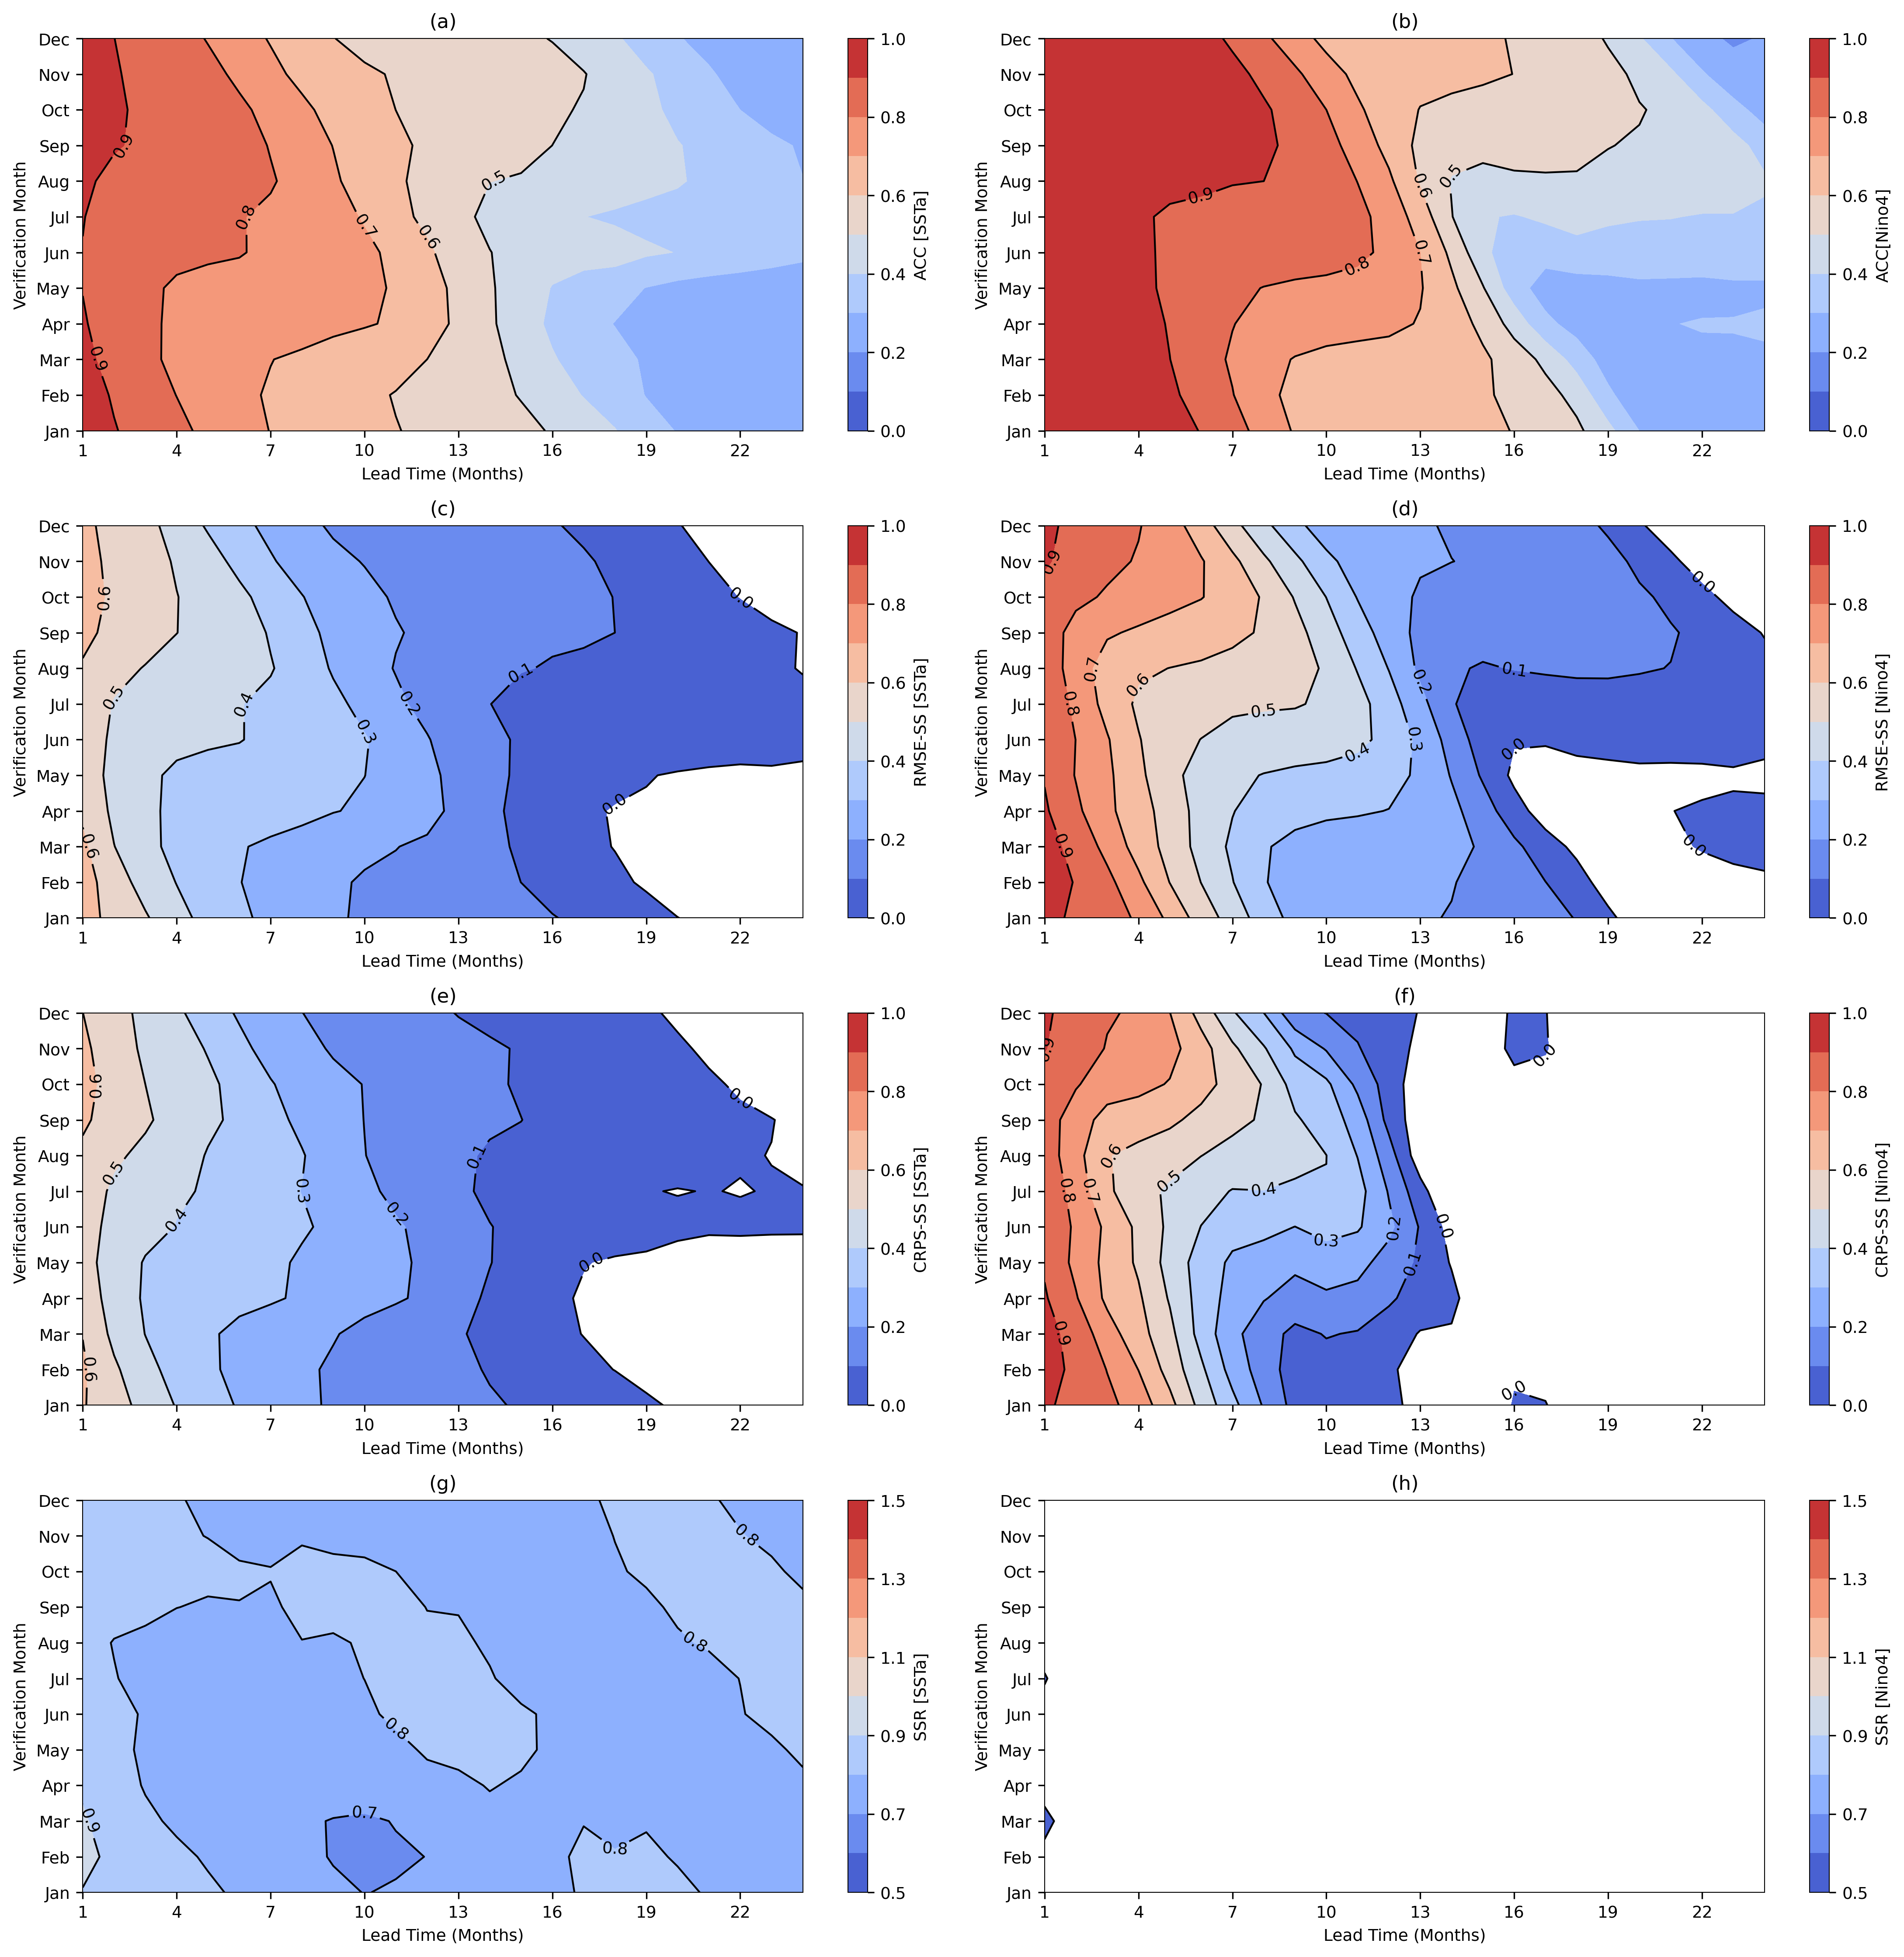

In [14]:
lev = np.linspace(0., 1., 11)
rmse_ss = (1 - monthly_rmse/clim_rmse)
nino_ss = (1 - monthly_nino_rmse/clim_nino_rmse)
crps_ss = (1 - monthly_crps/clim_crps)
nino_crps_ss = (1 - monthly_nino_crps/clim_nino_crps)

cmap = "coolwarm"

plt.figure(figsize = (15, 15))
plt.subplot(4, 2, 1)
filled = plt.contourf(monthly_accs.values, cmap = cmap, levels = lev)
contours = plt.contour(monthly_accs.values, levels = np.linspace(0.5, 1, 6), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(a)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "ACC [SSTa]")
plt.subplot(4, 2, 2)
filled = plt.contourf(monthly_nino_accs.values, cmap = cmap, levels = lev)
contours = plt.contour(monthly_nino_accs.values, levels = np.linspace(0.5, 1, 6), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(b)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "ACC[Nino4]")

plt.subplot(4, 2, 3)
filled = plt.contourf(rmse_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(rmse_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(c)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "RMSE-SS [SSTa]")
plt.subplot(4, 2, 4)
filled = plt.contourf(nino_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(nino_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(d)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "RMSE-SS [Nino4]")

plt.subplot(4, 2, 5)
filled = plt.contourf(crps_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(crps_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(e)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "CRPS-SS [SSTa]")
plt.subplot(4, 2, 6)
filled = plt.contourf(nino_crps_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(nino_crps_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(f)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "CRPS-SS [Nino4]")

plt.subplot(4, 2, 7)
filled = plt.contourf(monthly_ssr.values, cmap = cmap, levels = np.linspace(0.5, 1.5, 11))
contours = plt.contour(monthly_ssr.values, levels = np.linspace(0.5, 1.5, 11), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(g)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "SSR [SSTa]")
plt.subplot(4, 2, 8)
filled = plt.contourf(monthly_nino_ssr.values, cmap = cmap, levels = np.linspace(0.5, 1.5, 11))
contours = plt.contour(monthly_nino_ssr.values, levels = np.linspace(0.5, 1.5, 11), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(h)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "SSR [Nino4]")
plt.tight_layout()

plt.savefig('monthly.png')
plt.show()

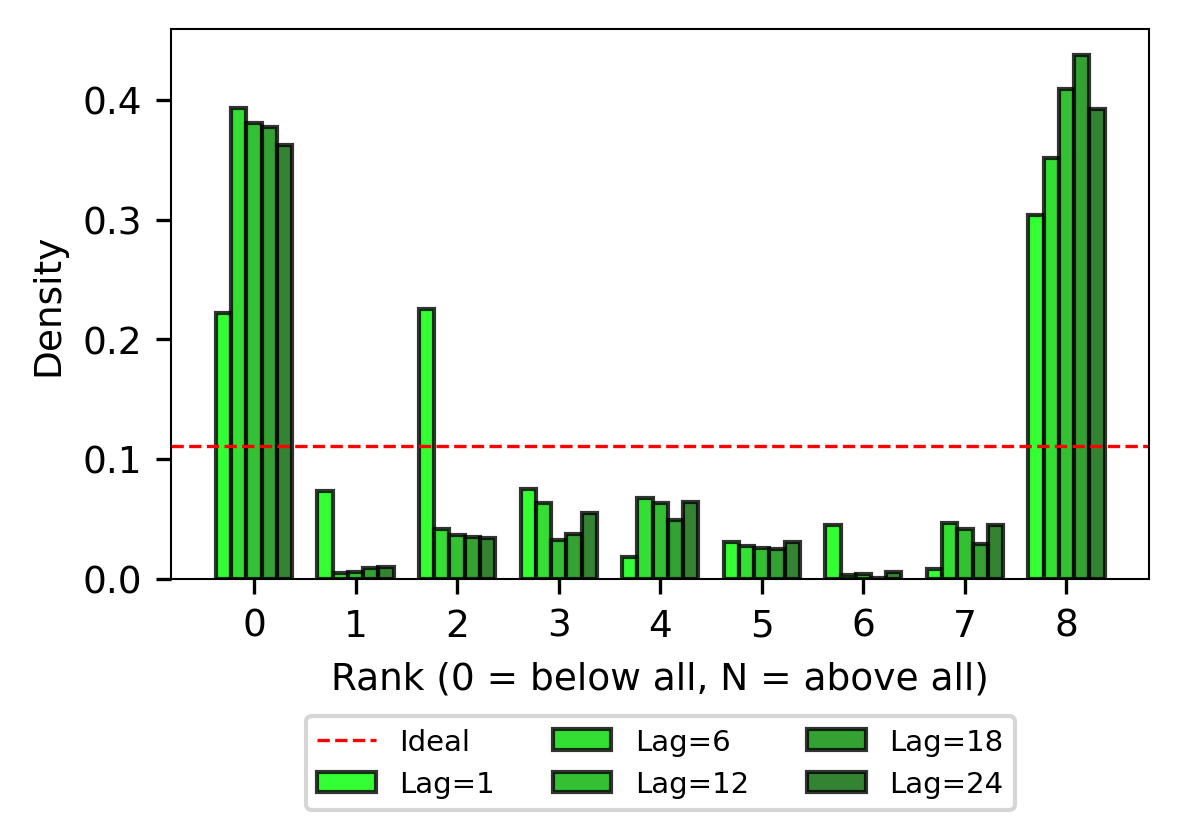

In [15]:
# 2) Define the lags you want to plot
lags_to_plot = [1, 6, 12, 18, 24]
n = len(lags_to_plot)

# 3) Create a color gradient from bright green (#00FF00) to dark green (#006400)
bright_hex = '#00FF00'
dark_hex   = '#006400'

green_gradient = []
for idx in range(n):
    alpha = idx / (n - 1)  # Goes from 0 to 1 as we move through lags
    # Linear interpolation between bright_green and dark_green
    green = [
        (1 - alpha) * mcolors.to_rgb(bright_hex)[ch] + alpha * mcolors.to_rgb(dark_hex)[ch]
        for ch in range(3)
    ]
    green_gradient.append(mcolors.to_hex(green))

# 2) Create a single figure and axis
fig, ax = plt.subplots(figsize=(4, 3))  # Adjust as needed

# 3) Loop over each representative lag and plot on the same axis
width = 0.15  # Bar width offset (adjust so bars don’t overlap)
colors = green_gradient  # Use the green gradient defined above

for i, lag_val in enumerate(lags_to_plot):
    # Select data for this lag
    obs_da = filtered_tgt_nino4.sel(lag=lag_val)
    ens_da = filtered_pred_nino4.sel(lag=lag_val)

    # 2. Convert xarray DataArray to numpy arrays
    obs = obs_da.values  # shape (M,)
    ens = ens_da.values  # shape (M, N)
    
    # Mask NaNs
    valid_mask = (~np.isnan(obs)) & (~np.isnan(ens).any(axis=1))
    obs_valid = obs[valid_mask]
    ens_valid = ens[valid_mask, :]
    
    # Compute rank histogram
    rank_counts = compute_rank_histogram(obs_valid, ens_valid)
    N = ens_valid.shape[1]  # number of ensemble members
    bins = np.arange(N + 1)
    
    # Offset each lag’s bars horizontally: bins + i*width
    ax.bar(bins + i * width,
           rank_counts,
           width=width,
           alpha=0.8,
           color=colors[i],
           edgecolor="black",
           label=f"Lag={lag_val}")

# 4) Final formatting
ax.set_ylabel("Density")
ax.set_xlabel("Rank (0 = below all, N = above all)")

# Optionally draw a reference line for a uniform distribution
# The expected count for a perfectly flat histogram:
expected_count = rank_counts.sum() / (N + 1)
ax.axhline(expected_count, color="red", linestyle="dashed", linewidth=0.8,
           label="Ideal")

# Position x-ticks in the middle of each "cluster"
ax.set_xticks(bins + (len(lags_to_plot)-1)*width/2)
ax.set_xticklabels(bins)

# Legend
fig.subplots_adjust(bottom=0.1)

# Create a legend with multiple columns, aligned horizontally below the x-axis
# loc='upper center' + bbox_to_anchor=(0.5, -0.2) 
#   places the legend center at x=0.5 horizontally,
#   and below the plot (negative y).
# borderaxespad=0.0 sets minimal extra padding.
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    borderaxespad=0.0,
    frameon=True  # remove the bounding box if you prefer
)


plt.tight_layout()
plt.savefig('rankhist.png')